In [1]:
import pandas as pd

data = pd.read_csv("../../dataset/dataset_final.csv")

In [2]:
features = data.drop('Target', axis=1)
target = data['Target']

Value Counts for Target:
Target
Dropout     2209
Graduate    2209
Enrolled    2209
Name: count, dtype: int64


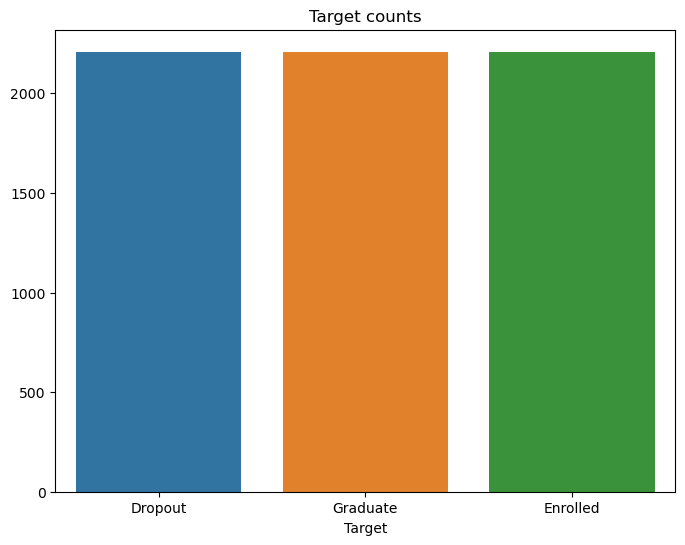

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

target_counts = target.value_counts()

print(f"Value Counts for Target:\n{target_counts}")
plt.figure(figsize=(8,6))
sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index)
plt.title('Target counts')
plt.show()

After OverSampling, the shape of train_X: (6627, 14)
After OverSampling, the shape of train_y: (6627,) 

Value Counts for Target:
Target
Dropout     2209
Graduate    2209
Enrolled    2209
Name: count, dtype: int64


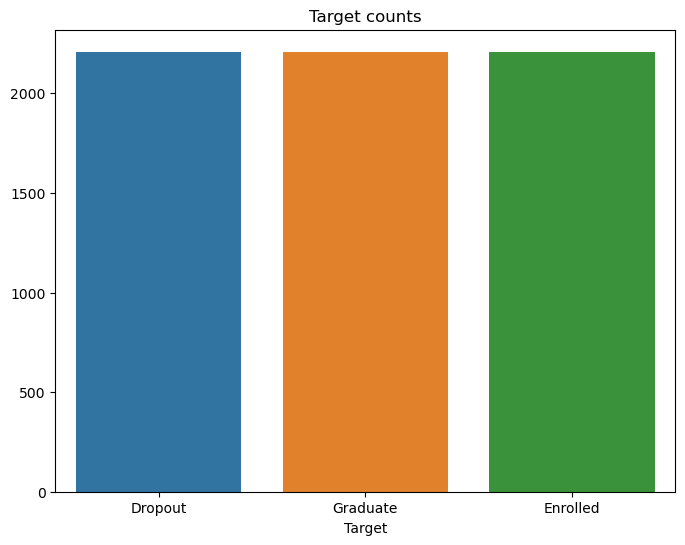

In [4]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)

features_train_res, target_train_res = sm.fit_resample(features, target)
X = features_train_res
y = target_train_res

print('After OverSampling, the shape of train_X: {}'.format(features_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(target_train_res.shape))

print(f"Value Counts for Target:\n{target_train_res.value_counts()}")
plt.figure(figsize=(8,6))
sns.barplot(x=target_train_res.value_counts().index, y=target_train_res.value_counts().values, hue=target_train_res.value_counts().index)
plt.title('Target counts')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split 

def split_data(X, y, train_size, test_size, val_size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=train_size, shuffle=True)
    if val_size is not None:
      X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, train_size=test_size/(test_size + val_size), shuffle=True)
      
      return X_train, X_test, X_val, y_train, y_test, y_val
    
    return X_train, X_test, pd.Series([]), y_train, y_test, pd.Series([])

# Data split explanation:
# First split (train vs rest):
#   - Training set: 70% of data (X_train, y_train)
#   - Remaining: 30% of data (for test and validation)
#
# Second split (test vs validation):
#   - Test set: 2/3 of remaining data = 20% of total data (X_test, y_test)
#   - Validation set: 1/3 of remaining data = 10% of total data (X_val, y_val)
#
# Final distribution:
#   - Training: 70%
#   - Testing: 20%
#   - Validation: 10%

X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y, 0.8, 0.2)
train = (X_train, y_train)
test = (X_test, y_test)
val = (X_val, y_val)

training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)
validation_data = pd.concat([X_val, y_val], axis=1)

# Check if the distribution is correct
total = X.shape[0]
print(f"Training data distribution {(training_data.value_counts().sum() / total):.0%}")
print(f"Testing data distribution {(testing_data.value_counts().sum() / total):.0%}")
print(f"Validation data distribution {(validation_data.value_counts().sum() / total):.0%}")

Training data distribution 80%
Testing data distribution 20%
Validation data distribution 0%


### **Support Vector Machine (SVM)**

Support Vector Machine (SVM) is a supervised machine learning algorithm used primarily for classification tasks, but it can also be applied to regression. SVM works by finding the hyperplane that best separates different classes in the feature space, maximizing the margin between data points of different classes.

#### Key Features:

-   **Classification**: SVM excels in binary and multi-class classification problems.
-   **Margin Maximization**: It tries to find the optimal hyperplane that maximizes the margin between different classes, which helps improve model generalization.
-   **Kernel Trick**: SVM can handle non-linear data by using kernel functions, transforming the feature space into a higher-dimensional space for better separation.
-   **Support Vectors**: The data points that are closest to the hyperplane are called support vectors, which are crucial in determining the optimal hyperplane.


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

svm_model = SVC()

# Define the grid of hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],               # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernels for SVM
    'gamma': ['scale', 'auto'],           # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2, 3, 4]                   # Degree for the polynomial kernel
}

grid_search = GridSearchCV(
  estimator=svm_model, 
  param_grid=param_grid, 
  scoring='accuracy',
  cv=5,          # 5-fold cross-validation
  verbose=1,     # Print messages
  n_jobs=-1      # Use all CPU cores for parallelization
  )     

In [7]:
X_train, y_train = train
X_test, y_test = test

# Step 4: Fit the model on the training set
print(f"Training model")
grid_search.fit(X_train, y_train)

# Step 5: Best parameters and model performance
print("Best Parameters:", grid_search.best_params_)
print("Best Training Accuracy:", grid_search.best_score_)

# Step 6: Evaluate on the Testing Set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

grid_search_results = grid_search.cv_results_

# Save the model
import joblib

joblib.dump(best_model, f"svm_model.pkl")

Training model
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Training Accuracy: 0.7824946205964469
Test Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

     Dropout       0.87      0.77      0.82       444
    Enrolled       0.74      0.81      0.78       439
    Graduate       0.79      0.81      0.80       443

    accuracy                           0.80      1326
   macro avg       0.80      0.80      0.80      1326
weighted avg       0.80      0.80      0.80      1326



['svm_model.pkl']

In [8]:
grid_search.best_params_

{'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

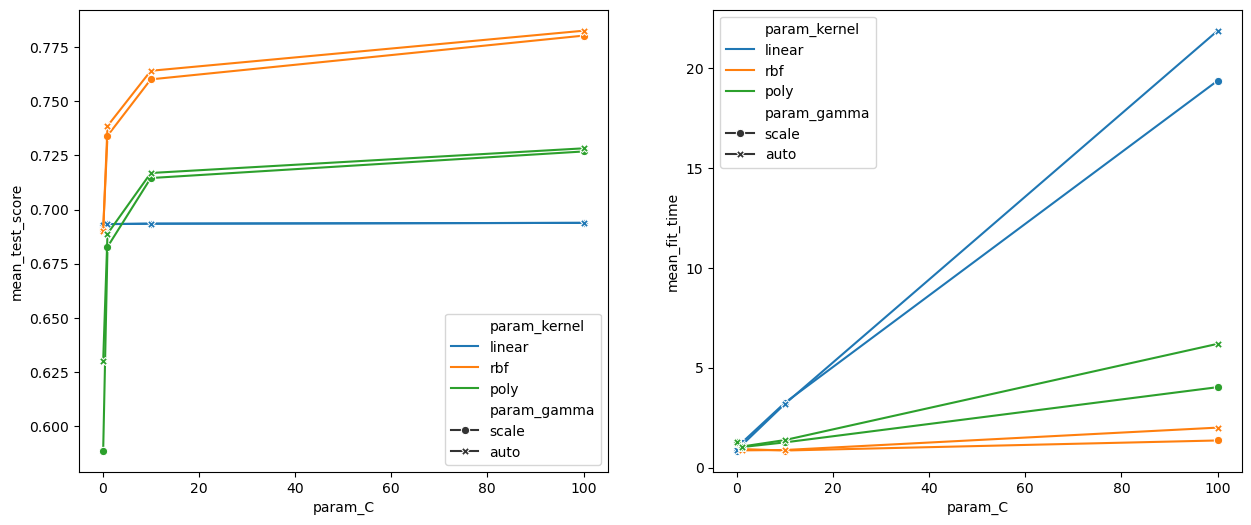

In [9]:
df_results = pd.DataFrame(grid_search_results)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=df_results, x='param_C', y='mean_test_score', hue='param_kernel', style='param_gamma', ax=ax[0], markers=True, dashes=False, err_style=None)
sns.lineplot(data=df_results, x='param_C', y='mean_fit_time', hue='param_kernel', style='param_gamma', ax=ax[1], markers=True, dashes=False, err_style=None)

plt.show()